In [32]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import numpy as np
from typing import Union
import math

In [33]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from lib.model_reduction_variant import Extractor
from lib.anomaly_detection import LOCIMatrix, LOCIMatrixNew
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.options.display.notebook_repr_html = False 
plt.rcParams['figure.dpi'] = 75 
sns.set_theme(style='darkgrid') 

In [34]:
from lib.model_utils import ModelUtil
model = ModelUtil(data_name = 'german_credit', model_name = 'RF')
paths = model.paths
mat = model.get_cover_matrix(model.X, fuzzy = True, byclass = True)

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [35]:
def rule_to_text(rule):
    conds = rule[0]
    ret = rule[1]
    return 'IF ' + ' AND '.join(['%s %s %s' % (str(a), str(b), str(c)) for (a, b, c) in conds]) + ' THEN ' + ret

In [36]:
res = LOCIMatrixNew(mat, r = 8, metric = 'euclidean', n_ticks=100)

In [35]:

res2 = LOCIMatrix(mat, alpha = 0.8, metric = 'euclidean')
res2.run()


r range: 1.414 - 18.654, alpha: 0.800


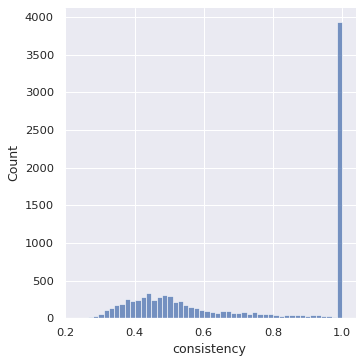

In [37]:
r = np.mean(res.sorted_dist[:, 20])# int(0.5 * np.sqrt(res.n_points))])
ret = res.check_consistency(r, [p['output'] for p in paths])
consistency_data = pd.DataFrame({ 'consistency': ret })
sns.displot(data=consistency_data, x="consistency", bins=50, log_scale=(False, False))
plt.show()

In [40]:
ret = np.array(ret)
rejects = [i for i, p in enumerate(model.paths) if p['output'] == 0]
accepts = [i for i, p in enumerate(model.paths) if p['output'] == 1]

In [42]:
rejects_top = [rejects[i] for i in ret[rejects].argsort()[:50]]
accepts_top = [accepts[i] for i in ret[accepts].argsort()[:50]]
print(ret[rejects_top][:5])
print(ret[accepts_top][:5])

[0.33333333 0.33333333 0.33333333 0.4        0.40171281]
[0.23404255 0.23417722 0.24137931 0.24347826 0.24378109]


In [38]:

idx = np.array(ret).argsort()[:50]


In [16]:
idx = np.array(ret).argsort()[:50]
from lib.model_utils import export_rules_to_csv
export_rules_to_csv('consistency_20_neighbors_top50.csv', model, idx)
idx.sort()
for it, i in enumerate(idx):
    print('#%d' % it, paths[i]['confidence'], ret[i], rule_to_text(model.interpret_path(model.paths[i])))
    print()

#0 0.875 0.2746478873239437 IF savings is not unknown/no savings account and < 100 DM AND credit_history is all credits at this bank paid back duly AND status is ... >= 200 DM (salary) AND number_credits is 1 THEN accept

#1 0.9285714285714286 0.25882352941176473 IF number_credits is not 2 to 3 AND credit_history is not no credits taken/all credits paid back duly AND status is ... >= 200 DM (salary) AND people_liable is 0 to 2 AND savings is 500 to 1000 DM or >= 1000 DM THEN accept

#2 0.9166666666666666 0.2891891891891892 IF number_credits is not 2 to 3 AND credit_history is no credits taken/all credits paid back duly AND savings is 100 to 500 DM AND purpose is not others AND status is ... >= 200 DM (salary) THEN accept

#3 0.5384615384615384 0.2724014336917563 IF duration <= 15 AND credit_history is no credits taken/all credits paid back duly AND amount <= 1538 AND housing is not rent AND job is skilled employee / official AND telephone is No AND property is not real estate THEN acce

In [1]:
import pickle
data = pickle.load(open('../output/german_0707.pkl', 'rb'))

In [4]:
paths = data['paths']

In [11]:
reps = [p for p in paths if p['represent']]
print(len(reps))

80


In [25]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

def predict(X, paths):
    Y = np.zeros(X.shape[0])
    for p in paths:
        ans = np.ones(X.shape[0])
        m = p.get('range')
        for key in m:
            ans = ans * (X[:,int(key)] >= m[key][0]) * (X[:,int(key)] < m[key][1])
        Y += ans * (p.get('weight') * p.get('value'))
    Y = np.where(Y > 0, 1, 0)
    return Y

In [29]:
y = predict(model.X_test, reps)

In [30]:
np.sum(y == model.y_test) / len(y)

0.32

In [81]:
res2.select_indice(11)
for i, p in enumerate(data['paths']):
    if p['represent']:
        print(p['confidence'], res2.outlier_score[i])
        print(rule_to_text(model.interpret_path(model.paths[i])))

0.9647058823529412 10.931754734062192
IF credit_history is all credits at this bank paid back duly AND status is ... >= 200 DM (salary) AND purpose is not others THEN accept
0.7916666666666666 10.029832117927164
IF savings is not unknown/no savings account and < 100 DM AND employment_duration is 4 to 7 yrs or >= 7 yrs AND installment_rate is not < 20 AND age <= 33 THEN accept
0.9629629629629629 6.921590650361733
IF duration <= 15 AND credit_history is no credits taken/all credits paid back duly AND amount in 1538 to 3290 AND age >= 25 THEN accept
0.9507042253521126 0.16486399723404424
IF duration >= 15 AND status is not ... >= 200 DM (salary) AND employment_duration is not 4 to 7 yrs and >= 7 yrs AND job is skilled employee / official AND savings is not 500 to 1000 DM and >= 1000 DM AND purpose is not car (used) AND telephone is No AND amount <= 6288 THEN reject
0.918918918918919 11.585649973952858
IF employment_duration is 4 to 7 yrs or >= 7 yrs AND housing is own AND purpose is not o

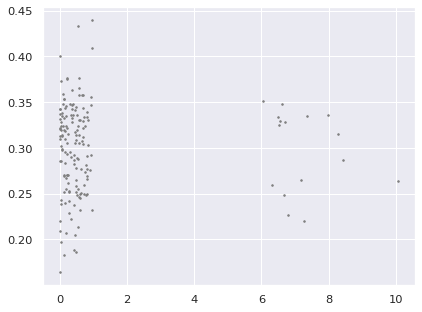

In [94]:
points = []
res2.select_indice(8)
for i in range(12, 9000, 10):
    if res2.outlier_score[i] > 1 and res2.outlier_score[i] < 6 or res2.outlier_score[i] < 0:
        continue
    conds_i = model.interpret_path(model.paths[i])[0]
    conds_i = [str(a) for (a, b, c) in conds_i] + [str(c) for (a, b, c) in conds_i]
    score = 0
    for j in res2.sorted_neighbors[i, 1: 21]:
        conds_j = model.interpret_path(model.paths[j])[0]
        conds_j = [str(a) for (a, b, c) in conds_j] + [str(c) for (a, b, c) in conds_j]
        iou = len([k for k in conds_j if k in conds_i])/ len(set(conds_i + conds_j))
        score += iou
    score /= 20
    points.append([res2.outlier_score[i], score])

points = np.array(points)
plt.scatter(points[:, 0], points[:, 1], s = 2, color='gray')
plt.show()

In [50]:
for i in res.sorted_neighbors[idx[0]][:10]:
    print(ret[i], res2.outlier_score[i], rule_to_text(model.interpret_path(model.paths[i])))
    print()

0.2529411764705882 -0.23100760401721104 IF savings is unknown/no savings account or < 100 DM AND property is not real estate AND purpose is not others AND status is not no checking account and ... < 0 DM AND amount <= 7973 AND housing is not for free AND credit_history is not all credits at this bank paid back duly AND present_residence is not 4 to 7 yrs and >= 7 yrs AND personal_status_sex is married male AND installment_rate is not >= 35 THEN accept

0.5803785077224277 -0.2689968599729133 IF telephone is No AND housing is own AND number_credits is 1 AND property is unknown / no property AND purpose is furniture/equipment THEN accept

0.4371061843640607 -0.2621255855790835 IF property is not unknown / no property AND telephone is No AND duration >= 35 AND status is not ... >= 200 DM (salary) AND number_credits is 2 to 3 AND credit_history is no credits taken/all credits paid back duly THEN reject

0.5817078456870395 -0.26735476340525693 IF housing is for free AND savings is not >= 100

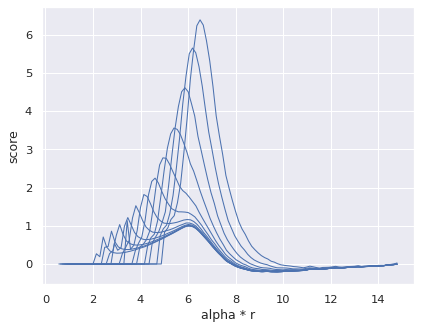

In [17]:
fig, ax = plt.subplots()
lines = []

idx = 3849
for exp in experiments:
    xs = np.array(exp.rs) * exp.alpha
    lines.append((xs, exp.scores[idx], 'b', idx))

import random
random.shuffle(lines)
for (xs, ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=1)
ax.set_xlabel('alpha * r')
ax.set_ylabel('score')
plt.show()

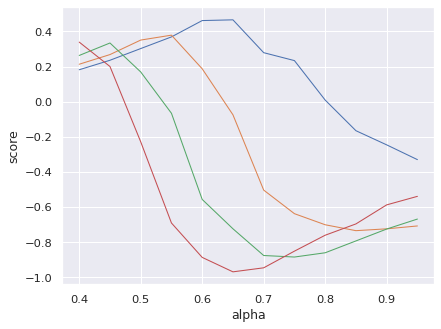

In [30]:
fig, ax = plt.subplots()
lines = []

idx = 2840
for alpha_r in range(6, 10):
    line = []
    for exp in experiments:
        i = np.flatnonzero(np.array(exp.rs) > alpha_r)[0]
        line.append([exp.scores[idx, i], exp.alpha])
    line = np.array(line)
    lines.append(line)

for line in lines:
    ax.plot(line[:, 1], line[:, 0], linewidth=1)
ax.set_xlabel('alpha')
ax.set_ylabel('score')
plt.show()

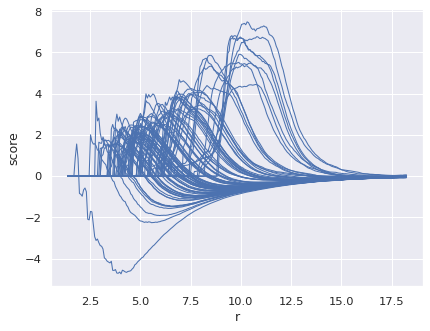

In [28]:
fig, ax = plt.subplots()
lines = []

xs = res.rs[:-5]
for x in range(2, 9000, 100):
    lines.append((res.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=1)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

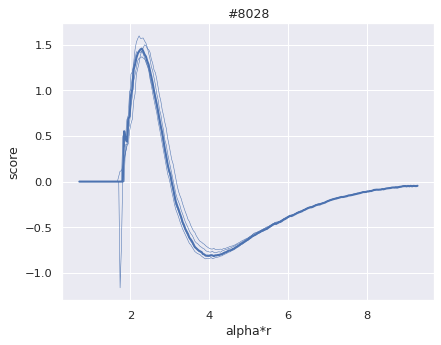

In [23]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 8028
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#8028')
plt.show()

In [24]:

idx = 8028
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

8028 IF housing is for free AND telephone is Yes AND status is not ... >= 200 DM (salary) AND other_installment_plans is none THEN reject
8551 IF other_installment_plans is none AND credit_history is not existing credits paid back duly till now AND status is not ... >= 200 DM (salary) AND telephone is Yes AND housing is for free THEN reject
7485 IF housing is for free AND savings is not >= 1000 DM AND property is not real estate AND telephone is Yes AND status is no checking account THEN accept
4205 IF status is not ... >= 200 DM (salary) AND housing is for free AND employment_duration is not unemployed AND personal_status_sex is married male AND telephone is Yes AND installment_rate is >= 35 THEN reject
5725 IF telephone is Yes AND duration <= 33 AND property is unknown / no property AND housing is for free AND status is not 0 to 200 DM and ... >= 200 DM (salary) THEN accept


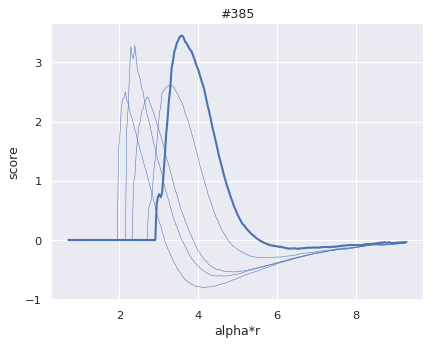

In [25]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 385
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#385')
plt.show()

In [40]:
idx = 385
idxes = res.sorted_neighbors[idx, :15]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

385 IF number_credits is 2 to 3 AND housing is own AND amount <= 7766 AND credit_history is all credits at this bank paid back duly AND duration >= 11 AND purpose is not others AND property is not real estate AND telephone is No THEN accept
8876 IF housing is own AND property is not real estate AND purpose is not others and furniture/equipment AND number_credits is not 1 AND savings is not >= 1000 DM AND telephone is No AND credit_history is all credits at this bank paid back duly THEN accept
8877 IF housing is own AND property is not real estate AND purpose is furniture/equipment AND number_credits is not 1 AND savings is not >= 1000 DM AND telephone is No AND credit_history is all credits at this bank paid back duly THEN accept
9459 IF property is not real estate AND other_installment_plans is not bank AND housing is own AND credit_history is all credits at this bank paid back duly AND telephone is No AND amount >= 4049 THEN accept
1741 IF credit_history is all credits at this bank p

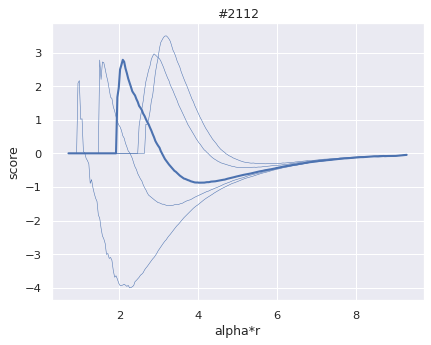

In [27]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 2112
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#2112')
plt.show()

In [15]:

idx = 2112
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

2112 IF status is ... >= 200 DM (salary) AND credit_history is not existing credits paid back duly till now AND telephone is No AND amount <= 3615 AND other_debtors is not none THEN accept
665 IF status is ... >= 200 DM (salary) AND credit_history is not existing credits paid back duly till now AND amount <= 3882 AND other_debtors is not none THEN accept
5218 IF status is ... >= 200 DM (salary) AND other_debtors is not none THEN accept
8389 IF duration <= 15 AND other_installment_plans is none AND purpose is not others AND credit_history is no credits taken/all credits paid back duly AND amount >= 804 AND other_debtors is co-applicant THEN accept
7089 IF savings is unknown/no savings account or < 100 DM AND telephone is No AND property is not building soc. savings agr./life insurance AND status is ... >= 200 DM (salary) AND people_liable is 3 or more AND housing is rent THEN accept


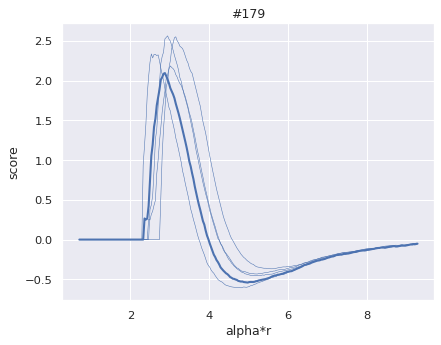

In [20]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 179
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#179')
plt.show()

In [17]:
idx = 179
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

179 IF savings is unknown/no savings account or < 100 DM AND property is real estate AND employment_duration is unemployed or < 1 yr AND housing is own AND age <= 32 THEN accept
180 IF savings is unknown/no savings account or < 100 DM AND property is real estate AND employment_duration is unemployed or < 1 yr AND housing is own AND age >= 32 THEN accept
5030 IF other_debtors is none AND savings is not 500 to 1000 DM and >= 1000 DM AND housing is own AND property is real estate AND amount >= 1082 AND age <= 25 THEN reject
3946 IF property is real estate AND employment_duration is unemployed or < 1 yr AND age <= 23 THEN accept
6752 IF property is real estate AND housing is not rent AND installment_rate is >= 35 AND duration >= 16 AND credit_history is not all credits at this bank paid back duly AND age <= 32 THEN accept


In [39]:
paths[385]['confidence']

0.7941176470588235

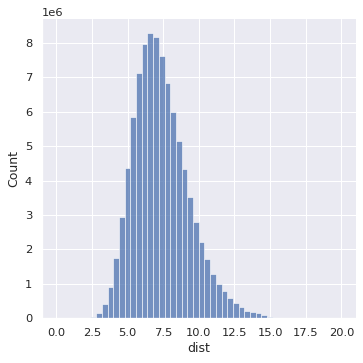

In [21]:
import seaborn as sns
import pandas as pd
dist_data = pd.DataFrame({ 'dist': res.sorted_dist[:, 1:].reshape(-1) })
sns.displot(data=dist_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

In [29]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, metric='precomputed').fit_transform(res.dist_matrix)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


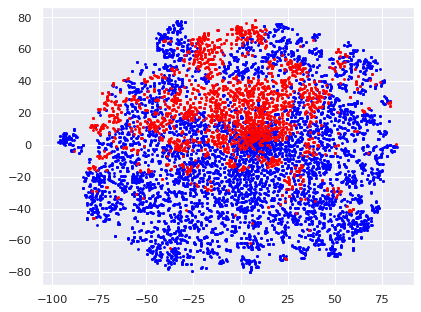

In [30]:
pos = [i for i in range(len(paths)) if paths[i]['output'] == 1]
neg = [i for i in range(len(paths)) if paths[i]['output'] == 0]
plt.scatter(x_tsne[pos, 0], x_tsne[pos, 1], s = 3, color='blue')
plt.scatter(x_tsne[neg, 0], x_tsne[neg, 1], s = 3, color='red')
plt.show()

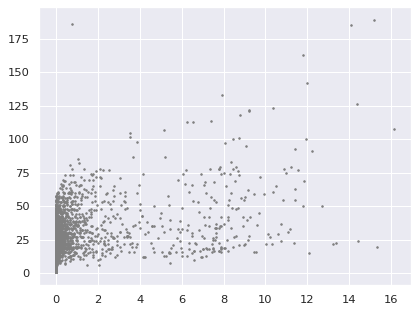

In [13]:
nums = np.array([np.sum(p['sample']) for p in paths])
plt.scatter(score, nums, s = 2, color='gray')
plt.show()

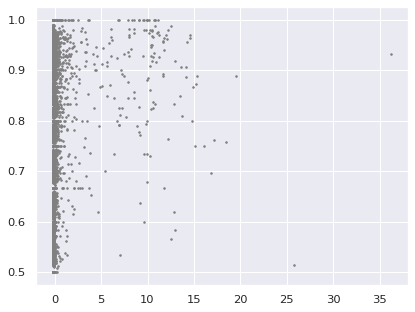

In [35]:
nums = np.array([np.sum(p['sample']) for p in paths])
conf = np.array([p['confidence'] for p in paths])

plt.scatter(res.outlier_score, conf, s = 2, color='gray')
plt.show()

In [17]:
curves = []
n = 80
tau = model.parameters['n_estimators'] * n / len(paths) * 0.5
lambda_ = 0
ex = Extractor(paths, model.X_train, model.clf.predict(model.X_train))
while lambda_ < 2:
    w, _, fidelity_train, obj = ex.extract(n, tau, lambda_)
    [idx] = np.nonzero(w)
    scores = [paths[i]['score'] for i in idx]
    avg_score = np.mean(scores)
    second_term = np.sum([paths[i]['cost'] for i in idx]) * lambda_
    first_term = obj - second_term
    accuracy_train = ex.evaluate(w, model.X_train, model.y_train)
    accuracy_test = ex.evaluate(w, model.X_test, model.y_test)
    fidelity_train = ex.evaluate(w, model.X_train, model.clf.predict(model.X_train))
    fidelity_test = ex.evaluate(w, model.X_test, model.clf.predict(model.X_test))
    print(lambda_, first_term, second_term, avg_score)

    curves.append((lambda_, first_term, 'fidelity'))
    curves.append((lambda_, second_term, 'score'))
    curves.append((lambda_, obj, 'obj'))
    f = open('../output/data/record_0707.txt', 'a')
    f.write('%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f\n' % (lambda_, first_term, second_term, obj, avg_score, fidelity_train, fidelity_test))
    f.close()
    lambda_ += 0.05

In [41]:
np.mean(res.outlier_score)

0.04534996481643857

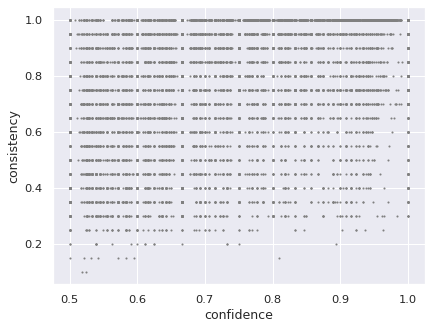

In [63]:
conf = [p['confidence'] for p in paths]
consistent = []
for i, p in enumerate(paths):
    count = 0
    for j in res.sorted_neighbors[i, 1: 21]:
        if paths[j]['output'] == paths[i]['output']:
            count += 1
    consistent.append(count / 20)
fig, ax = plt.subplots()
plt.scatter(conf, consistent, s = 1, color='gray')
ax.set_xlabel('confidence')
ax.set_ylabel('consistency')
plt.show()

In [64]:
vec = np.array([[conf[i], consistent[i]] for i in range(len(consistent))]).astype('float')
counts = np.zeros((10, 10))
for i in range(10):
    x1 = (9 - i) * 0.1
    for j in range(10):
        x2 = j * 0.1
        counts[i, j] = np.sum((vec[:, 0] > x1) * (vec[:, 0] <= x1 + 0.1) * (vec[:, 1] > x2) * (vec[:, 1] <= x2 + 0.1))
print(counts)

[[   0.    0.   22.   57.   60.   66.  140.  251.  144. 1084.]
 [   0.    2.   24.   60.   64.   72.  159.  213.  183.  847.]
 [   0.    3.   46.  123.  127.  110.  212.  236.  298.  781.]
 [   0.    5.   84.  194.  203.  207.  257.  268.  305.  518.]
 [   2.   13.  126.  252.  258.  247.  290.  267.  213.  268.]
 [   0.    3.   27.   54.   33.   32.   42.   39.   33.   37.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


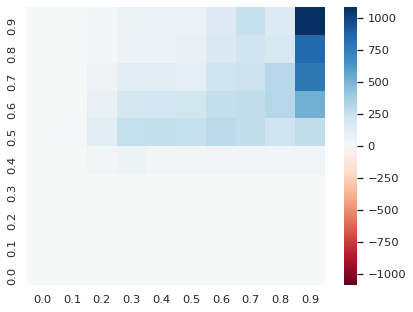

In [73]:
f, ax = plt.subplots()
ax = ax.invert_yaxis()
sns.heatmap(counts, cmap="RdBu", ax=ax, vmin=-counts.max(),
    xticklabels = [round(i * 0.1, 2) for i in range(10)],
    yticklabels = [round(0.9 - i * 0.1, 2) for i in range(10)]
    )
plt.show()